# ConvLSTM Predicting Model

ConvLSTM for Spatiotemporal Pattern Recognition

Goal: Incorporate geospatial and weather data (raster layers) to predict migration density.

Why? ConvLSTM processes both time-series data and spatial patterns, making it ideal for predicting regional movement trends.

•    Architecture:
◦    Input: Time-sequenced weather maps & migration density maps.
◦    ConvLSTM layers extract spatial-temporal dependencies.
◦    Output: Heatmap of predicted migration densities.
◦    Use Case: Helps visualize how weather conditions affect migration routes.
Assigned:

•    Jake - Feature engineering, data cleaning, and exploratory analysis.
•    Tania - Model training, hyperparameter tuning, and performance evaluation.

set of predictive coordinates

pulling weather API (through TIFF file) from NOAA to import to workspace

pick top 5 weather parameters.

to generalize and avoid overfitting use samples from the data



In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

# Load the dataset
df = pd.read_csv("ShortTermSetData(Aug-Sept).csv")

# Define the features
features = [
    'event-id', 'visible', 'timestamp', 'location-long', 'location-lat',
    'bar:barometric-height', 'external-temperature', 'gps:hdop', 'gps:satellite-count',
    'heading', 'height-above-msl', 'import-marked-outlier', 'mag:magnetic-field-raw-x',
    'mag:magnetic-field-raw-y', 'mag:magnetic-field-raw-z', 'individual-taxon-canonical-name',
    'tag-local-identifier'
]

# Convert non-numeric columns into numeric ones (Label Encoding for categorical data)
# Drop 'timestamp' column if it's not useful for model, or convert it into a numeric feature
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Handle categorical columns like 'individual-taxon-canonical-name' and 'sensor-type' (if present)
label_cols = ['individual-taxon-canonical-name', 'sensor-type']

for col in label_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Handle boolean columns like 'visible' and 'import-marked-outlier'
df['visible'] = df['visible'].astype(int)
df['import-marked-outlier'] = df['import-marked-outlier'].astype(int)

# Selecting only the relevant columns
data = df[features].dropna()

# Normalize the data
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Prepare sequences for time series prediction, per duck
def create_sequences_for_duck(data, seq_length=5):
    X, y = [], []
    # Group data by 'tag-local-identifier'
    for tag, group in data.groupby('tag-local-identifier'):
        group = group.sort_values(by='timestamp')  # Sort the data by timestamp

        # Create sequences for each group (duck)
        for i in range(len(group) - seq_length):
            X.append(group.iloc[i:i+seq_length][features].values)
            y.append(group.iloc[i+seq_length][['location-lat', 'location-long']].values)

    return np.array(X), np.array(y)

seq_length = 5
X, y = create_sequences_for_duck(scaled_data, seq_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model with an Input layer
model = Sequential([
    Input(shape=(seq_length, len(features))),  # Specify the input shape here
    LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(30, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(2)  # Predicting lat & long
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mse'])

# Early stopping to prevent overfitting by monitoring the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model with more epochs
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=1)

# Plot the learning curve (Training and Validation Loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Evaluate the model with RMSE
from sklearn.metrics import mean_squared_error
import math

# Predict on test data
y_pred = model.predict(X_test)

# Compute RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')


KeyboardInterrupt: 

In [ ]:
#To display map and a key (NEEDS ADJUSTED)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure for legend
fig, ax = plt.subplots(figsize=(4, 2))
ax.axis("off")  # Remove axes

# Define legend symbols
predicted_patch = mpatches.Patch(color='red', label='Predicted Locations')
historical_patch = mpatches.Patch(color='blue', label='Historical Data')

# Add legend
ax.legend(handles=[predicted_patch, historical_patch], loc='center')

# Show legend
plt.show()

from IPython.display import display
display(m)

# Map visualization
m = folium.Map(location=[df['location-lat'].mean(), df['location-long'].mean()], zoom_start=6)

# Collect historical data (locations) and add them as individual points (blue)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['location-lat'], row['location-long']],
        radius=3,  # Set the size of the points
        color='purple',  # Blue color for historical data points
        fill=True,
        fill_color='purple',  # Ensures it is filled with blue
        fill_opacity=0.7  # Adjust opacity if needed
    ).add_to(m)

# Collect predicted locations for future predictions (lat, long)
predicted_locations = y_pred.tolist()

# Add predicted locations as a HeatMap layer
HeatMap(predicted_locations, radius=40, blur=30, max_zoom=15, min_opacity=0.4).add_to(m)

# Display the map
from IPython.display import display
display(m)

# Save the map to an HTML file
# m.save("duck_flight_prediction.html")

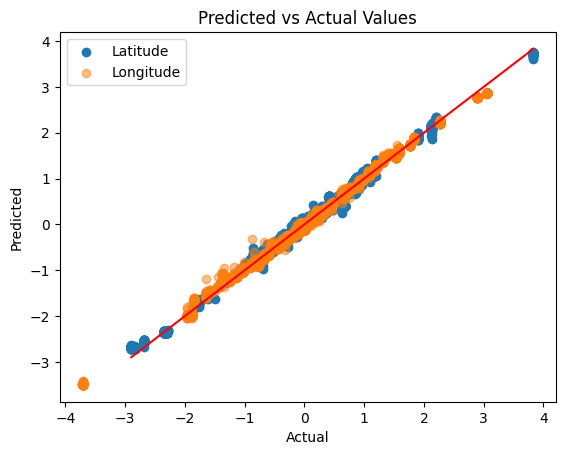

In [ ]:
plt.scatter(y_test[:, 0], y_pred[:, 0], label='Latitude')
plt.scatter(y_test[:, 1], y_pred[:, 1], label='Longitude', alpha=0.5)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

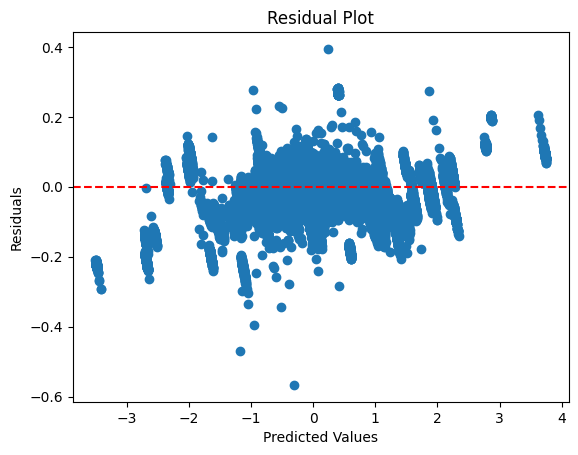

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

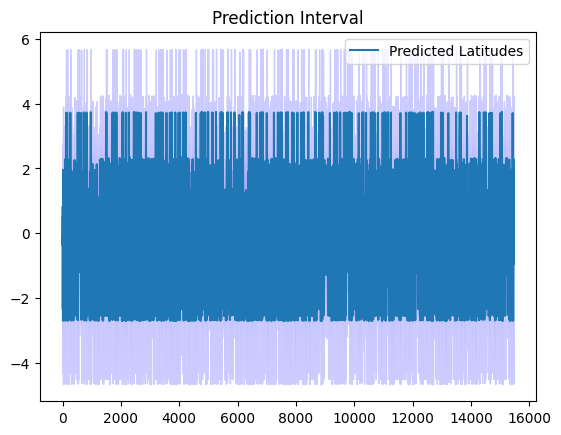

In [ ]:
lower_bound = y_pred - 2 * np.std(y_pred, axis=0)
upper_bound = y_pred + 2 * np.std(y_pred, axis=0)

plt.fill_between(range(len(y_pred)), lower_bound[:, 0], upper_bound[:, 0], color='blue', alpha=0.2)
plt.plot(y_pred[:, 0], label="Predicted Latitudes")
plt.title('Prediction Interval')
plt.legend()
plt.show()

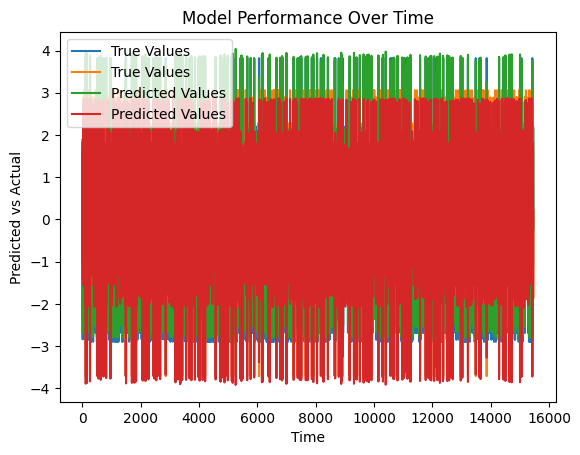

In [ ]:
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.title('Model Performance Over Time')
plt.xlabel('Time')
plt.ylabel('Predicted vs Actual')
plt.legend()
plt.show()

In [ ]:
#model attempt 2
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset
df = pd.read_csv("ShortTermSetData(Aug-Sept).csv")

# Selecting relevant features
features = ['location-lat', 'location-long', 'ground-speed', 'heading']
data = df[features].dropna()

# Prepare sequences for time series prediction
def create_sequences(data, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length][['location-lat', 'location-long']].values)
    return np.array(X), np.array(y)

seq_length = 5
X, y = create_sequences(data, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    LSTM(50, activation='relu'),
    Dense(2)  # Predicting lat & long
])

model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict future locations
future_predictions = model.predict(X_test[:10])

# Output the predicted coordinates
print("Predicted coordinates:")
for i, coord in enumerate(future_predictions):
    print(f"Prediction {i+1}: Latitude {coord[0]}, Longitude {coord[1]}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 279.5444 - val_loss: 0.6310
Epoch 2/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6802 - val_loss: 0.7253
Epoch 3/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5581 - val_loss: 0.2561
Epoch 4/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.4086 - val_loss: 0.1964
Epoch 5/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3190 - val_loss: 0.3928
Epoch 6/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2699 - val_loss: 0.2072
Epoch 7/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2892 - val_loss: 0.2062
Epoch 8/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2873 - val_loss: 0.3893
Epoch 9/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2394 - val_loss: 0.2192
Epoch 10/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2911 - val_loss: 0.1419
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
Predicted coordinates:
Prediction 1: Latitude 45.3797492980957, Longitude -